In [2]:
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib.pyplot as plt
import nibabel as nib

from sklearn.decomposition import NMF
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import adjusted_rand_score
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import rand_score
from nibabel.nifti1 import Nifti1Image


def load_data(hemisphere):
    X = pd.read_csv('https://raw.githubusercontent.com/JonahKember/hippocampus_clustering/main/' + hemisphere + '_nmf_input_raw.csv')
    X = X.to_numpy()
    return(X)

def run_nmf(X,k):
    
    '''1. Rescale columns of X to the interval [0,1].
    2. Run Non-Negative matrix factorization on X with k components.'''

    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    
    model = NMF(n_components = k, init = 'random', max_iter = 10000)
    model.fit_transform(X)
    
    W = model.transform(X)
    clusters = np.argmax(W,1)

    return(clusters, model)

def get_nmf_similarity(X, k, n_shuffle = 5):
    
    '''Calculate the stability of NMF components. 
    1. Randomly split the matrix X in half n_shuffle times.
    2. Run NMF on each half (with k components).
    3. Calculate the adjusted Rand index between the clusters output from each half.'''

    rand_indices = np.zeros(n_shuffle)

    for split in range(n_shuffle):

        # Generate randomly shuffled indices (seed set for reproducibility).
        np.random.seed(split)
        idx = np.split(np.random.permutation(X.shape[1]),2)

        # Get NMF clusters for each split.
        clust_1 = run_nmf(X[:,idx[0]],k)[0]
        clust_2 = run_nmf(X[:,idx[1]],k)[0]

        # Calculate the adjusted Rand index.
        rand_indices[split] = adjusted_rand_score(clust_1,clust_2)
        
    print('Similarity for k = '+ str(k) + ' is ' + str(np.mean(rand_indices)))
    
    return(rand_indices)

def get_nmf_error(X, k_vals = np.arange(1,10)):
    
    '''Calculate the reconstruction error of NMF components.''' 

    error = np.zeros(len(k_vals) + 1)

    for k in k_vals:

        # Get NMF clusters for each split.
        model = run_nmf(X,k)[1]
        error[k] = model.reconstruction_err_
        
        print('Reconstruction error for k = '+ str(k) + ' is ' + str(np.mean(error[k])))
    
    return(error)


def clusters_to_nii(k, hemisphere,clusters):

    if hemisphere == 'right':
        hem_label = 1
    elif hemisphere == 'left':
        hem_label = 2

    # Open majority-vote label.
    majority_vote = nib.load('majority_vote_label.nii')

    # Get nifti file information.
    labels = majority_vote.get_fdata()

    # Initialize empty matrix, fill with cluster labels, write to nifti.
    nii = np.zeros(labels.shape, dtype = np.float64)
    nii[labels == hem_label] = clusters
    nii = Nifti1Image(nii, affine = majority_vote.affine, header = majority_vote.header)

    nib.save(nii, str(hemisphere + '_nmf_clusters_k' + str(k) + '.nii.gz'))




For testing PCA versus NMF:

In [3]:
from sklearn.decomposition import PCA

def run_pca(X,k):
    
    scaler = MinMaxScaler()
    X = scaler.fit_transform(X)
    
    model = PCA(n_components = k)
    model.fit_transform(X)
    
    W = model.transform(X)
    clusters = np.argmax(W,1)

    return(clusters, model)

X = load_data('right')

run_pca(X,4)

(array([3, 3, 3, ..., 1, 1, 1]), PCA(n_components=4))

## Non-negative matrix factorization
Across a range of _k_ values, test the similarity of NMF components identified on halved samples. Similarity is calculated via the commonly used adjusted Rand index.

In [4]:
# Number of data-set splits.
n_shuffle = 5

# Number of k-values to explore.
n_k = 15

X = load_data('right')

# Track similarity of NMF components across range of k-values.
k_similarity = np.zeros([n_k,n_shuffle])
for k in range(1,n_k):
    k_similarity[k,:] = get_nmf_similarity(X, k, n_shuffle = n_shuffle)
    


Similarity for k = 1 is 1.0
Similarity for k = 2 is 0.7702696010785463
Similarity for k = 3 is 0.8236438865852627
Similarity for k = 4 is 0.7043723755753316
Similarity for k = 5 is 0.6308250528341178
Similarity for k = 6 is 0.3874659322514677
Similarity for k = 7 is 0.3608253610044692
Similarity for k = 8 is 0.41995025807143904
Similarity for k = 9 is 0.43212430881642805
Similarity for k = 10 is 0.4217914542818252
Similarity for k = 11 is 0.3657218857115949
Similarity for k = 12 is 0.3382577440146944
Similarity for k = 13 is 0.2328704689778832
Similarity for k = 14 is 0.3375606391175672


Across a range of _k_ values, calculate the reconstruction error. 

In [18]:
# Number of k-values to explore.
k_vals = np.arange(1,15)
X = load_data('right')

error = get_nmf_error(X, k_vals = k_vals)


Reconstruction error for k = 1 is 149.70925147108275
Reconstruction error for k = 2 is 134.7568822869316
Reconstruction error for k = 3 is 123.35212191310734
Reconstruction error for k = 4 is 116.0976903543768
Reconstruction error for k = 5 is 110.84375989923478
Reconstruction error for k = 6 is 106.64189183272042
Reconstruction error for k = 7 is 103.01681838515745
Reconstruction error for k = 8 is 99.89156052172429
Reconstruction error for k = 9 is 96.96991098685129
Reconstruction error for k = 10 is 94.42769395540233
Reconstruction error for k = 11 is 92.24202470635916
Reconstruction error for k = 12 is 90.33064371259161
Reconstruction error for k = 13 is 88.489988990466
Reconstruction error for k = 14 is 86.82158703482926


Plot the similarity and reconstruction errors as functions of _k_.

Text(0, 0.5, 'Reconstruction error')

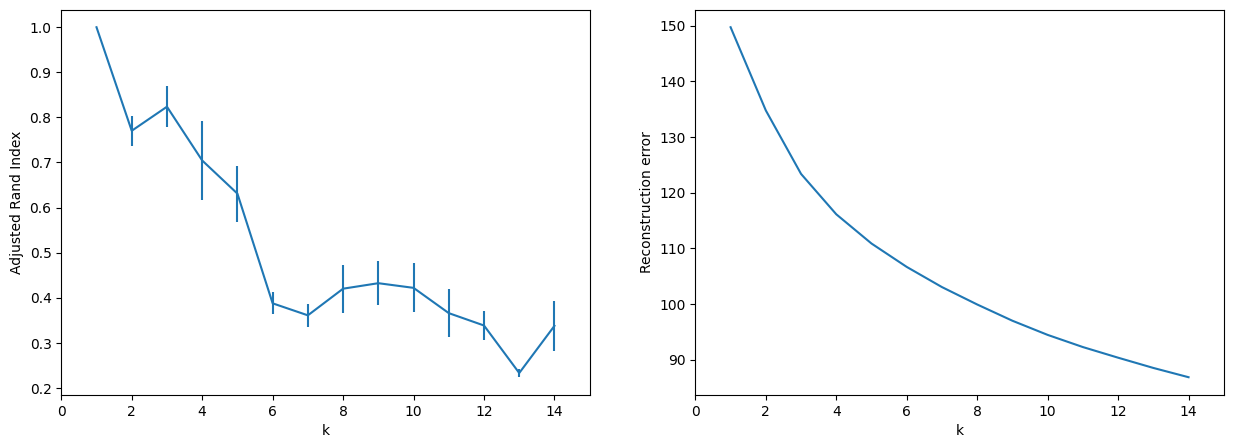

In [19]:
# Plot the similarity.
x = np.arange(k_similarity.shape[0])
y = np.mean(k_similarity,1)
yerr = np.std(k_similarity, axis = 1)/np.sqrt(k_similarity.shape[1])

fig, ax = plt.subplots(1,2, figsize=(15,5))
ax[0].errorbar(x[1:],y[1:], yerr = yerr[1:])

ax[0].set_xlim([0,15])
ax[0].set_xlabel('k')
ax[0].set_ylabel('Adjusted Rand Index')

# Plot the reconstruction error.
x = np.arange(error.shape[0])
ax[1].plot(x[1:],error[1:])

ax[1].set_xlim([0,15])
ax[1].set_xlabel('k')
ax[1].set_ylabel('Reconstruction error')

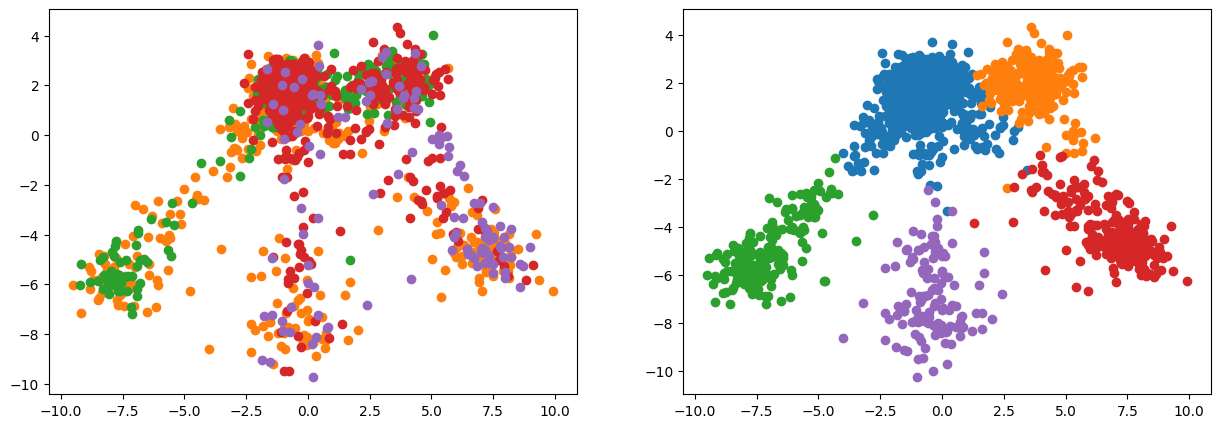

In [7]:
# Load subfield labels.
y = pd.read_csv('right_subfield_labels.csv')
y = y.to_numpy()
y = y.reshape(y.shape[0],)

clusters = run_nmf(X,5)[0]

model = LinearDiscriminantAnalysis(n_components = 2)
model.fit_transform(X,clusters)
lda_components = model.transform(X)

# Plot Subfields against NMF components in LDA space. 
fig, ax = plt.subplots(1,2,figsize = [15,5])

for k in range(np.max(clusters) + 1):
    ax[0].plot(lda_components[y == k,0], lda_components[y == k,1], marker='o', linestyle='')    
    ax[1].plot(lda_components[clusters == k,0], lda_components[clusters == k,1], marker='o', linestyle='') 

plt.show()


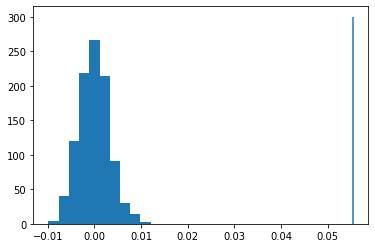

In [502]:
# Test where the empirical Rand index falls in a distribution of null-Rand indices (created through 1000 row-permutations).

empirical = adjusted_rand_score(y,clusters)

n_perm = 1000
null_vars = np.zeros(n_perm)

for perm in range(n_perm):
    np.random.seed(perm)
    null_vars[perm] = adjusted_rand_score(y,np.random.permutation(clusters))

plt.hist(null_vars)
plt.vlines(empirical,ymin = 0, ymax = 300)


## Comparison with HCP components identified by Raihann

In [504]:
majority_vote = nib.load('majority_vote_label.nii')
hcpd = nib.load('right_components_k5.nii')
hcp = nib.load('raihann_warped.nii.gz')


labels = majority_vote.get_fdata()

hcpd = hcpd.get_fdata()
hcpd = hcpd[labels == 1]

hcp = hcp.get_fdata()
hcp = hcp[labels == 1]
hcp = np.round(hcp)

hcpd = hcpd.astype(int)
hcp = hcp.astype(int)

print(hcpd)
print(hcp)
adjusted_rand_score(hcpd,hcp)


[1 1 1 ... 0 0 0]
[1 1 2 ... 4 4 1]


0.14621217678046305

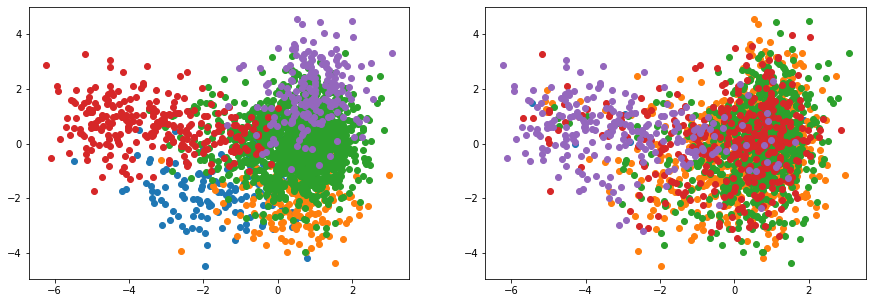

In [497]:

model = LinearDiscriminantAnalysis(n_components = 2)
model.fit_transform(X,hcpd)
lda_components = model.transform(X)

# Plot Subfields against NMF components in LDA space. 
fig, ax = plt.subplots(1,2,figsize = [15,5])

for k in range(5):
    ax[0].plot(lda_components[hcpd == k,0], lda_components[hcpd == k,1], marker = 'o', linestyle = '')    
    ax[1].plot(lda_components[hcp == k,0], lda_components[hcp == k,1], marker = 'o', linestyle = '') 

plt.show()

# Partial Least Squares

In [287]:

def get_age(hemisphere):
    Y = pd.read_csv(hemisphere + '_age.csv')
    age = Y['Age'].to_numpy()
    return(age)

def get_X_pls(X,k):
    
    n_subjects = int(X.shape[1]/3)
    
    model = run_nmf(X,k)[1]
    H = model.components_
    
    metric_idx = np.arange(0,n_subjects*3,n_subjects)
    metric_idx = np.append(metric_idx, n_subjects*3)

    X_metric_split = np.split(H,metric_idx, axis = 1)
    X_pls = np.vstack((X_metric_split[1],X_metric_split[2],X_metric_split[3])).T

    return(X_pls)


In [277]:
# Prep data for PLS.
hemisphere = 'right'
k = 5

age = get_age(hemisphere)
X_pls = get_X_pls(load_data(hemisphere),k)


[1.18572004e-02 1.76907975e-03 1.44594561e-03 6.20025857e-04
 2.34555372e-04 4.23480314e-04 6.55995141e-04 3.40522481e-04
 2.27085370e-03 8.26422415e-04 4.83727730e-04 2.27267897e-04
 7.28521315e-05 1.91466531e-04 4.27010477e-06]


Text(0, 0.5, 'Component 1 scores')

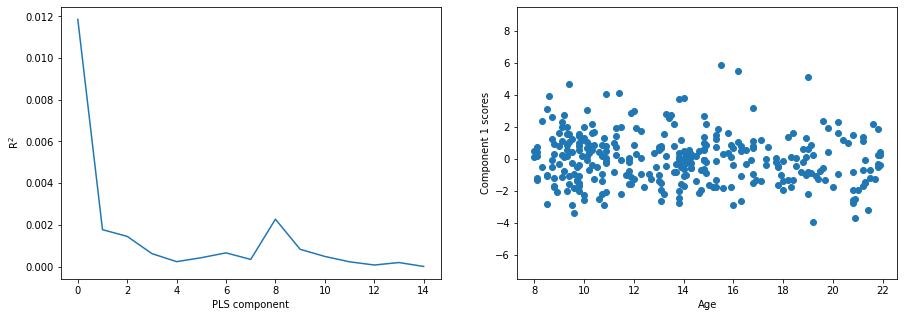

In [286]:
from sklearn.cross_decomposition import PLSRegression

n_comp = 15

model = PLSRegression(n_components=n_comp)
model.fit(X_pls,age)

x_scores = model.x_scores_
x_weights = model.x_weights_

age_corrs = np.zeros(n_comp)
for n in range(n_comp):
    age_corrs[n] = np.corrcoef(x_scores[:,n],age)[0,1]

print(age_corrs**2)

fig, ax = plt.subplots(1,2,figsize = [15,5])

ax[0].plot(age_corrs**2)
ax[0].set_ylabel('R$^2$')
ax[0].set_xlabel('PLS component')

ax[1].plot(age,x_scores[:,0],marker='o', linestyle='')
ax[1].set_ylim(-7.5,9.5)
ax[1].set_xlabel('Age')
ax[1].set_ylabel('Component 1 scores')


In [5]:
X = load_data('right')
X.shape


(2220, 948)